In [169]:
from __future__ import print_function
import argparse
import torch
from PIL import Image
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt

import numpy as np

In [170]:
output_filename = "out.png"
dataset = 'BSD300'

#parser.add_argument('--cuda', action='store_true', help='use cuda')

In [171]:

if torch.cuda.is_available():
    device_name = 'cuda'
else:
    device_name = 'cpu'
    
device = torch.device(device_name)
    
#torch.manual_seed(seed)

In [172]:
def load_model(model_name, dataset, epoch, factor, device_name):
    #print(model.state_dict()['conv1.W_mu'][0])
    
    model = torch.load(f'super_resolution/models/{model_name}/{dataset}/epoch_{epoch}_upscale_factor_{factor}_device_{device_name}.pth').to(device)
    print(model)
    return model

In [173]:
def set_var_scale(model, scale):
    model.conv1.variance_scale = scale
    model.conv2.variance_scale = scale
    model.conv3.variance_scale = scale
    model.conv4.variance_scale = scale

In [174]:
    
def convert_to_image(y, cb, cr, fname):
    out_img_y = y * 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    #print(cb.shape)
    #print(y.shape)
    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    # out_img_cb = cb[0] *  255
    # out_img_cr = cr[0] *  255
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    
    print('saved to ', fname)
    out_img.save(fname)
    plt.imshow(out_img)
    plt.show()

In [175]:
def upscale_image(model, input_image, variance_scale=1):
    img = Image.open(input_image).convert('YCbCr')
    y, cb, cr = img.split()

    img_to_tensor = ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)
    
    model = model.cpu()
    set_var_scale(model, variance_scale)
    model = model.to(device)
    out, kl = model(input)
    out = out.cpu()
    out = out[0].detach().numpy()
    
    print("Image with variance scale of", variance_scale)
    fname = f"variance_{variance_scale}_{output_filename}"
    convert_to_image(out, cb, cr, fname)

In [176]:
model = load_model("BayesianNet", dataset=dataset, epoch=1, factor=3, device_name=device_name)

BayesianNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (conv2): BBBConv2d()
  (act2): ReLU()
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


In [177]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# for variance_scale in [0, 1, 2, 5, 100]:
#     upscale_image(model, input_image, variance_scale)

In [178]:
from super_resolution.data import get_test_set
test_set = get_test_set(3, dataset=dataset)

input, target, cb, cr = test_set.getitem_full(5)

In [179]:
from super_resolution.data import get_test_set

def test_comparison(model, upscale_factors, input_image="./super_resolution/dataset/coco/images/val2017/000000057027.jpg", dataset=dataset):
    img = Image.open(input_image).convert('YCbCr')
    y, cb, cr = img.split()
    
    img_to_tensor = ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device).squeeze()
    print(input.shape)
    resize_transform = Resize((img.height//upscale_factors, img.width//upscale_factors))
    resized_img = resize_transform(input.unsqueeze(dim=0).unsqueeze(dim=0))
    # resized_img = img_to_tensor(resized_img)
    print(resized_img.shape)
    print(input.shape)
    
    print("Original image:")     
    convert_to_image(input.unsqueeze(dim=0), cb, cr, "original_image.png")
    
    
    print("Cropped image:")     
    convert_to_image(resized_img.squeeze().unsqueeze(dim=0), cb, cr, "cropped_image.png")
    

    print("Upscaled cropped image:")
    t = torch.unsqueeze(input, dim=0).to(device)
    
    if 'Bayesian' in model.__class__.__name__:
        out, kl = model(t)
        # out, kl = model(out)
    else:
        out = model(t)
    
    out = out.unsqueeze(dim=0).cpu()
    out = out[0].detach().numpy()
    
    convert_to_image(out, cb, cr, "upscaled_cropped_image.png")

In [180]:
model = load_model("BayesianNet", dataset=dataset, epoch=1, factor=3, device_name=device_name)

BayesianNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (conv2): BBBConv2d()
  (act2): ReLU()
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


torch.Size([426, 640])
torch.Size([1, 1, 142, 213])
torch.Size([426, 640])
Original image:
saved to  original_image.png


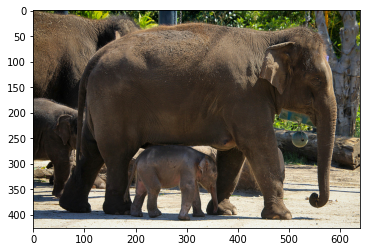

Cropped image:
saved to  cropped_image.png


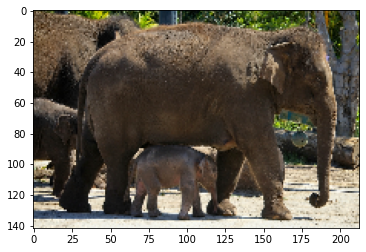

Upscaled cropped image:
saved to  upscaled_cropped_image.png


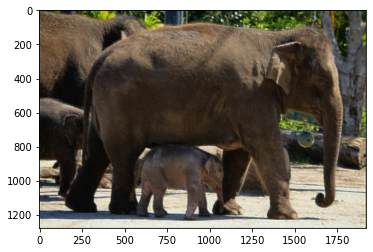

In [181]:
input_image = "./super_resolution/dataset/BSDS300/images/test/3096.jpg"
test_comparison(model, 3)

In [182]:
model = load_model("BayesianNet", dataset=dataset, epoch=1, factor=3, device_name=device_name)

BayesianNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (conv2): BBBConv2d()
  (act2): ReLU()
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


Image with variance scale of 0
saved to  variance_0_out.png


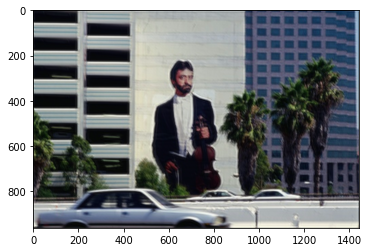

Image with variance scale of 1
saved to  variance_1_out.png


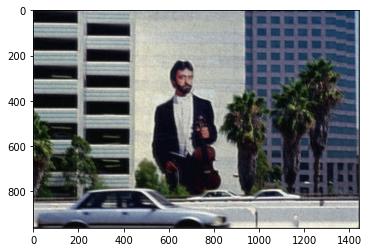

Image with variance scale of 2
saved to  variance_2_out.png


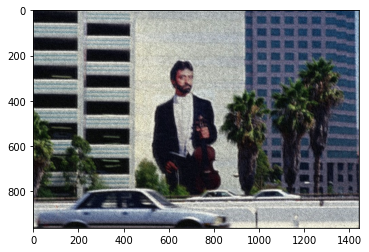

Image with variance scale of 5
saved to  variance_5_out.png


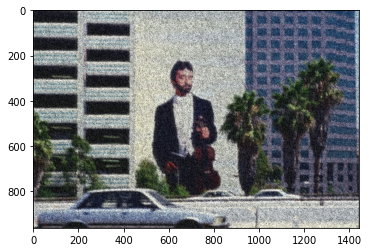

Image with variance scale of 100
saved to  variance_100_out.png


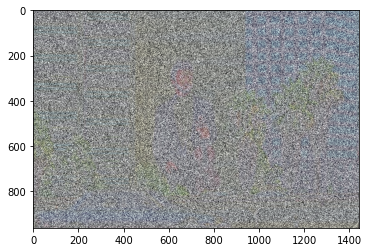

In [183]:
input_image = "super_resolution/dataset/BSDS300/images/test/119082.jpg" 
for var_scale in [0, 1, 2, 5, 100]:
    set_var_scale(model, var_scale)
    upscale_image(model, input_image, var_scale)

In [185]:
model = load_model("Net", dataset='coco', epoch=1, factor=3, device_name=device_name)

Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


In [186]:
def test_image(model, input_image, output_filename = "out.png"):
    img = Image.open(input_image).convert('RGB')
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

    plt.imshow(img)
    plt.show()
    y, cb, cr = img.convert('YCbCr').split()

    img_to_tensor = ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)
    model = model.to(device)
    
    if 'Bayesian' in model.__class__.__name__:
        out, kl = model(input)
        # out, kl = model(out)
    else:
        out = model(input)
    out = out.cpu()
    out = out[0].detach().numpy()
    
    fname = f"./outputs/testing_{output_filename}"
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    convert_to_image(out, cb, cr, fname)

In [187]:
test_image(model, ".\super_resolution\patterns\pattern (6).jpg")

FileNotFoundError: [Errno 2] No such file or directory: '.\\super_resolution\\patterns\\pattern (6).jpg'